In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from read_data import get_vid_path, build_data_set
from helper_func import show_frames

In [3]:
NUM_FRAME = 16
RESOLUTION = 128
CHANNEL = 3

## Part 1: PCA Compression

Read Data and prepare X_train, X_test

In [4]:
from sklearn.preprocessing import MinMaxScaler
paths = get_vid_path()
X = build_data_set(paths)

scaler = MinMaxScaler()
scaler.fit(X.reshape(49 * 16, -1))
X = scaler.transform(X.reshape(49*16, -1)).reshape(49*16, 128, 128, 3)

X_train = X[:40*16,:,:,:]
X_test = X[40*16:,:,:,:]

In [5]:
X_train.max()
print(X_train.mean())
print((X_train > 100).sum())

0.01857233273009327
0


In [6]:
X_test.max()
print(X_test.mean())
print((X_test > 100).sum())

0.02452141595577815
0


PCA compress and decompress

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA()
pca.fit(X_train.reshape(len(X_train), -1));

In [9]:
cum = np.cumsum(pca.explained_variance_ratio_)

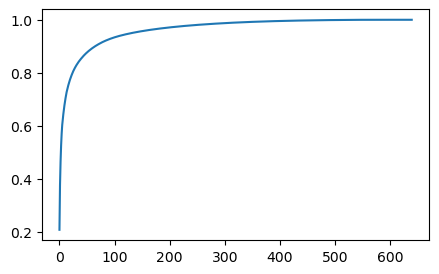

In [10]:
plt.figure(figsize=(5,3))
plt.plot(cum)

In [11]:
num_pc = np.sum(cum < 0.95)
print(num_pc)

132


In [12]:
pca = PCA(n_components=num_pc)
pca.fit(X_train.reshape(len(X_train), -1));

In [13]:
X_test_trans = pca.transform(X_test.reshape(len(X_test), -1))
X_test_inver = pca.inverse_transform(X_test_trans)\
    .reshape(9*16, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


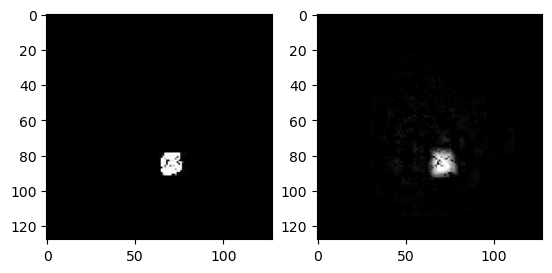

In [14]:
def compare_pca(X_test, X_test_inver, idx):
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[idx])
    plt.subplot(1, 2, 2)
    plt.imshow(X_test_inver[idx])

compare_pca(X_test, X_test_inver, 3)

## Part 2: CAE for Video Frame Compress

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
from torchvision.transforms import Lambda
from CAE import VideoFrame, Encoder, Decoder

Construct data set and dataloaders:

In [16]:
batch_size = 32

transform = Lambda(lambda x: x / 255.)

X_train = VideoFrame(split='train', transform=transform)
X_test = VideoFrame(split='test', transform=transform)

X_train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
X_test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [17]:
lr = 1e-3

encoder = Encoder()
decoder = Decoder()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(
    params_to_optimize, lr=lr, weight_decay=1e-05
)
loss_fn = torch.nn.MSELoss()

In [18]:
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch(encoder, decoder, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [19]:
num_epochs = 20
diz_loss = {
    'train_loss':[],
    'val_loss':[]
}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder, X_train_loader,loss_fn,optimizer)
   val_loss = test_epoch(encoder,decoder, X_test_loader,loss_fn)
   print(
    'EPOCH {}/{} \t train loss {} \t val loss {}'\
        .format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

EPOCH 1/20 	 train loss 0.030710577964782715 	 val loss 0.02061915583908558
EPOCH 2/20 	 train loss 0.014862226322293282 	 val loss 0.02012181095778942
EPOCH 3/20 	 train loss 0.01465057022869587 	 val loss 0.019724391400814056
EPOCH 4/20 	 train loss 0.01423962414264679 	 val loss 0.018969496712088585
EPOCH 5/20 	 train loss 0.013409937731921673 	 val loss 0.017733676359057426
EPOCH 6/20 	 train loss 0.012508337385952473 	 val loss 0.015694664791226387
EPOCH 7/20 	 train loss 0.009967222809791565 	 val loss 0.012296225875616074
EPOCH 8/20 	 train loss 0.007892417721450329 	 val loss 0.010377828031778336
EPOCH 9/20 	 train loss 0.006621614098548889 	 val loss 0.009362752549350262
EPOCH 10/20 	 train loss 0.005838771350681782 	 val loss 0.008256607688963413
EPOCH 11/20 	 train loss 0.00528848497197032 	 val loss 0.007634293753653765
EPOCH 12/20 	 train loss 0.004892834462225437 	 val loss 0.007483990862965584
EPOCH 13/20 	 train loss 0.004588957875967026 	 val loss 0.007018360774964094


In [20]:
sample = next(iter(X_test_loader))
code = encoder(sample)
res = decoder(code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


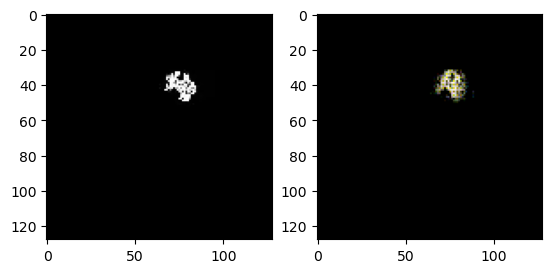

In [21]:
def compare_cae(sample, res, idx):
    plt.subplot(1, 2, 1)
    plt.imshow(sample[idx].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(res[idx].permute(1, 2, 0).detach())

compare_cae(sample, res, 10)

## Part 3: compare models

In this case, 3 different reduced space dimensions was choosen: 8, 16, 32

first, train 3 different PCA models with mentioned reduced space:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from read_data import get_vid_path, build_data_set

from sklearn.preprocessing import MinMaxScaler
paths = get_vid_path()
X = build_data_set(paths)

scaler = MinMaxScaler()
scaler.fit(X.reshape(49 * 16, -1))
X = scaler.transform(X.reshape(49*16, -1)).reshape(49*16, 128, 128, 3)

X_train = X[:40*16,:,:,:]
X_test = X[40*16:,:,:,:]


pca_list = []

for n_dim in [8, 16, 32]:
    pca_list.append(
        PCA(n_components=n_dim).fit(X_train.reshape(len(X_train), -1))
    )

then train 3 CAE with according reduced code length:

In [29]:
batch_size = 32
transform = Lambda(lambda x: x / 255.)

X_train_cae = VideoFrame(split='train', transform=transform)
X_test_cae = VideoFrame(split='test', transform=transform)

X_train_loader = DataLoader(X_train_cae, batch_size=batch_size, shuffle=True)
X_test_loader = DataLoader(X_test_cae, batch_size=batch_size, shuffle=True)

cae_list = []

for n_dim in [8, 16, 32]:
    model_encoder = Encoder(code_dim=n_dim)
    model_decoder = Decoder(code_dim=n_dim)
    num_epochs = 20
    diz_loss = {
        'train_loss':[],
        'val_loss':[]
    }
    params_to_optimize = [
        {'params': model_encoder.parameters()},
        {'params': model_decoder.parameters()}
    ]
    optimizer = torch.optim.Adam(
        params_to_optimize, lr=1e-3, weight_decay=1e-05
    )
    loss_fn = torch.nn.MSELoss()
    for epoch in range(num_epochs):
        train_loss =train_epoch(model_encoder,model_decoder, X_train_loader,loss_fn,optimizer)
        val_loss = test_epoch(model_encoder,model_decoder, X_test_loader,loss_fn)
        diz_loss['train_loss'].append(train_loss)
        diz_loss['val_loss'].append(val_loss)
        print(
                'EPOCH {}/{} \t train loss {} \t val loss {}'\
                    .format(epoch + 1, num_epochs,train_loss,val_loss))
        diz_loss['train_loss'].append(train_loss)
        diz_loss['val_loss'].append(val_loss)
        if (epoch == num_epochs - 1):
            print(
            'Model： train loss {} \t val loss {}\n'\
                .format(train_loss,val_loss))
    cae_list.append((model_encoder, model_decoder))


EPOCH 1/20 	 train loss 0.023242546245455742 	 val loss 0.020955141633749008
EPOCH 2/20 	 train loss 0.015208050608634949 	 val loss 0.0206158384680748
EPOCH 3/20 	 train loss 0.01507653295993805 	 val loss 0.02036595344543457
EPOCH 4/20 	 train loss 0.014791028574109077 	 val loss 0.019662292674183846
EPOCH 5/20 	 train loss 0.01425742544233799 	 val loss 0.019156744703650475
EPOCH 6/20 	 train loss 0.013682423159480095 	 val loss 0.016665102913975716
EPOCH 7/20 	 train loss 0.010354379191994667 	 val loss 0.01178794540464878
EPOCH 8/20 	 train loss 0.007049776613712311 	 val loss 0.008658462204039097
EPOCH 9/20 	 train loss 0.005134484730660915 	 val loss 0.006948790047317743
EPOCH 10/20 	 train loss 0.004402863793075085 	 val loss 0.006693804636597633
EPOCH 11/20 	 train loss 0.003786098212003708 	 val loss 0.00619496451690793
EPOCH 12/20 	 train loss 0.003385714488103986 	 val loss 0.0057145231403410435
EPOCH 13/20 	 train loss 0.0031764886807650328 	 val loss 0.00556248938664794
E

In [24]:
def visualize_model(pca, cae, model_idx, pic_idx):
    pca = pca[model_idx]
    encoder, decoder = cae[model_idx]
    X_inverse_pca = pca.inverse_transform(
        pca.transform(X_test.reshape(len(X_test), -1))
    ).reshape(9*16, 128, 128, 3)

    transform = Lambda(lambda x: x / 255.)
    X_transformed = transform(X_test_cae.data)
    X_inverse_cae = decoder(encoder(
        X_transformed.data.permute(0, 3, 1, 2)
    ))
    print(X_inverse_cae.shape)
    # plot for pca comparison
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[pic_idx])
    plt.title('original version')
    plt.subplot(1, 3, 2)
    plt.imshow(X_inverse_pca[pic_idx])
    plt.title('pca reconstruction')
    plt.subplot(1, 3, 3)
    plt.imshow(X_inverse_cae.detach().permute(0, 2, 3, 1)[pic_idx])
    plt.title('cae reconstruction')



A Reconstruction comparision with reduced code of length 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([144, 3, 128, 128])


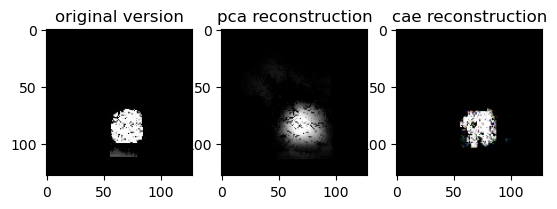

In [25]:
visualize_model(pca_list, cae_list, 0, 9)

A Reconstruction comparision with reduced code of length 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([144, 3, 128, 128])


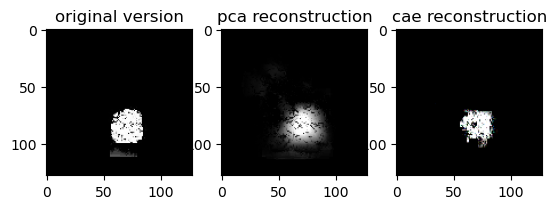

In [26]:
visualize_model(pca_list, cae_list, 1, 9)

A Reconstruction comparision with reduced code of length 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([144, 3, 128, 128])


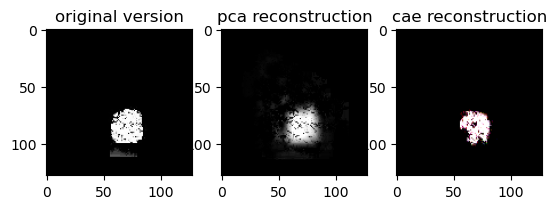

In [30]:
visualize_model(pca_list, cae_list, 2, 9)

Conclusion: with increased code dimension, PCA tends to perform better while CAE based method performs worse. This could be explained by the fact PCA with more components can mimic the original input better while adding reduced code dimesion for CAE models could lead to overfitting.